<a href="https://colab.research.google.com/github/CeciSC/LSTMEquityIndexPrediction/blob/main/csi300_RNN_daily.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Add S&P 500 and HS300

In [1]:
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

print(tf.__version__)


2.3.0


In [2]:
from keras.layers import Input, Dense, LSTM
from keras.models import Model
from keras.layers import *
from keras.models import *
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
import time

In [4]:
from google.colab import files
uploaded = files.upload()

Saving hs300.csv to hs300.csv


# New Section

In [6]:
import pandas as pd
import io

df = pd.read_csv(io.StringIO(uploaded['hs300.csv'].decode('utf-8')))
df

,date,close,open,high,low,volume,x(t-1),x(t-2),x(t-3),MA5,MA10,MA20,BIAS5,BIAS10,DIFF,BU,BL,KDJ,KDJ(t-1),ROC,TR（14）,MTM6,MTM12,WR%10,WR%5,OSC6,OSC12,RSI6,RSI12,PSY,OBV,return,(x(t)-xo(t))/xo(t),(x(t)-xl(t))/(xh(t)- xl(t)),(MA5(t)-MA5(t-1))/MA5(t-1),(MA20(t)-MA20(t-1))/MA20(t-1),(MA5(t)-MA20(t-1))/MA20(t-1),(x(t)-MA20(t))/MA20(t)
0,1/4/10,3535.2290,3592.4680,3597.7480,3535.2290,6610108000,3575.6840,3575.6800,3558.8570,3529.79,3455.11850,3508.973800,0.1541,2.3186,-0.7398,3708.899235,3326.960919,77.7282,76.9618,-0.7160,66.1354,96.4120,-25.4940,20.7390,37.906844,-0.1607,-1.912190,58.214907,53.424573,66.666667,15761101790,-0.0113,-0.0159,0.0000,0.006258,-0.003031,0.004383,0.007482
1,1/5/10,3564.0380,3545.1860,3577.5260,3497.6610,8580964100,3535.2290,3575.6840,3575.6840,3546.91,3471.86010,3503.734100,0.4829,2.6550,4.4354,3708.705230,3341.118616,81.4247,77.7282,2.4104,68.8372,139.2550,83.8850,11.1824,22.999093,0.2994,-1.908078,63.228944,55.993992,75.000000,15846911431,0.0081,0.0053,0.8311,0.004850,-0.001493,0.010811,0.017211
2,1/6/10,3541.7270,3558.7000,3588.8320,3541.1730,7847312500,3564.0380,3535.2290,3575.6840,3555.11,3495.47850,3499.619500,-0.3764,1.3231,6.6597,3709.891699,3342.244301,80.3912,81.4247,4.4223,67.9544,63.2940,149.9920,18.5835,55.972304,0.5634,-1.574446,56.885306,53.500459,66.666667,15768438306,-0.0063,-0.0048,0.0116,0.002311,-0.001174,0.014663,0.012032
3,1/7/10,3471.4560,3543.1600,3558.5560,3452.7690,8035003700,3541.7270,3564.0380,3535.2290,3537.63,3508.97610,3495.468400,-1.8705,-1.0693,2.7208,3707.066967,3338.194033,64.4253,80.3912,2.2032,67.8967,-29.2810,74.8340,48.8652,87.110547,0.5234,-1.293455,41.245343,46.400698,66.666667,15688088269,-0.0198,-0.0202,0.1766,-0.004917,-0.001186,0.010861,-0.006870
4,1/8/10,3480.1300,3456.9080,3482.0830,3426.6980,6079025300,3471.4560,3541.7270,3564.0380,3518.52,3513.10740,3490.613050,-1.0910,-0.9387,0.2957,3700.756318,3335.489374,53.3627,64.4253,5.2816,65.1044,-78.7270,174.5870,62.8701,68.762350,0.2812,-0.742377,43.544489,47.341688,66.666667,15748878522,0.0025,0.0067,0.9647,-0.005402,-0.001389,0.006595,-0.003003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2426,12/25/19,3990.8671,3988.6574,4000.5556,3976.3559,9493889000,3992.9581,3967.0962,4017.2527,3999.06,3991.66975,3931.248280,-0.2050,-0.0201,29.5162,4050.547309,3789.291191,59.0441,65.4477,2.4495,36.8824,-50.9325,95.4203,42.1334,67.250737,2.1166,1.426661,56.018210,58.590802,50.000000,41770235585,-0.0005,0.0006,0.5996,-0.002092,0.001468,0.018743,0.015165
2427,12/26/19,4025.9879,3993.6686,4025.9879,3993.5413,10886064000,3990.8671,3992.9581,3967.0962,3998.83,4005.16612,3939.432530,0.6791,0.5199,31.3967,4061.172471,3787.752475,60.6246,59.0441,3.2203,37.6992,-6.7947,125.6036,29.0058,24.967494,1.9755,1.571487,66.959028,63.912328,50.000000,41879096225,0.0088,0.0081,1.0000,-0.000058,0.002082,0.017191,0.021972
2428,12/27/19,4022.0278,4029.2454,4066.7964,4019.7223,15092641100,4025.9879,3990.8671,3992.9581,3999.79,4010.54679,3949.100390,0.5560,0.2863,32.1963,4070.493169,3788.618685,59.2181,60.6246,3.0563,39.1533,-5.1217,119.2786,39.6995,43.409408,1.8273,1.688829,64.778650,62.917741,50.000000,41728169814,-0.0010,-0.0018,0.0490,0.000239,0.002454,0.015321,0.018467
2429,12/30/19,4081.6334,4015.5195,4083.6901,4001.4951,15597148800,4022.0278,4025.9879,3990.8671,4022.69,4019.95549,3961.379115,1.4652,1.5343,37.2108,4087.226847,3789.703361,72.2409,59.2181,4.8987,43.6764,64.3807,190.6092,1.7136,1.713563,1.8678,1.855955,77.822341,70.464660,50.000000,41884141302,0.0148,0.0165,0.9750,0.005727,0.003109,0.018635,0.030357


In [7]:
df.dtypes

date                              object
close                            float64
open                             float64
high                             float64
low                              float64
volume                             int64
x(t-1)                           float64
x(t-2)                           float64
x(t-3)                           float64
MA5                              float64
MA10                             float64
MA20                             float64
BIAS5                            float64
BIAS10                           float64
DIFF                             float64
BU                               float64
BL                               float64
KDJ                              float64
KDJ(t-1)                         float64
ROC                              float64
TR（14）                           float64
MTM6                             float64
MTM12                            float64
WR%10                            float64
WR%5            

In [9]:
df[['volume']] = df[['volume']].astype('float')
df[['OBV']] = df[['OBV']].astype('float')

# df_feature = df[['Close','Open','High','Low','Volume']]
# df_feature.columns = [['close','open','high','low','volume']]
# df_feature.head()
df_feature = df
df_feature = df_feature.drop(['date'], axis=1)
df_feature.head()

,close,open,high,low,volume,x(t-1),x(t-2),x(t-3),MA5,MA10,MA20,BIAS5,BIAS10,DIFF,BU,BL,KDJ,KDJ(t-1),ROC,TR（14）,MTM6,MTM12,WR%10,WR%5,OSC6,OSC12,RSI6,RSI12,PSY,OBV,return,(x(t)-xo(t))/xo(t),(x(t)-xl(t))/(xh(t)- xl(t)),(MA5(t)-MA5(t-1))/MA5(t-1),(MA20(t)-MA20(t-1))/MA20(t-1),(MA5(t)-MA20(t-1))/MA20(t-1),(x(t)-MA20(t))/MA20(t)
0,3535.229,3592.468,3597.748,3535.229,6.610108e+09,3575.684,3575.680,3558.857,3529.79,3455.1185,3508.97380,0.1541,2.3186,-0.7398,3708.899235,3326.960919,77.7282,76.9618,-0.7160,66.1354,96.412,-25.494,20.7390,37.906844,-0.1607,-1.912190,58.214907,53.424573,66.666667,1.576110e+10,-0.0113,-0.0159,0.0000,0.006258,-0.003031,0.004383,0.007482
1,3564.038,3545.186,3577.526,3497.661,8.580964e+09,3535.229,3575.684,3575.684,3546.91,3471.8601,3503.73410,0.4829,2.6550,4.4354,3708.705230,3341.118616,81.4247,77.7282,2.4104,68.8372,139.255,83.885,11.1824,22.999093,0.2994,-1.908078,63.228944,55.993992,75.000000,1.584691e+10,0.0081,0.0053,0.8311,0.004850,-0.001493,0.010811,0.017211
2,3541.727,3558.700,3588.832,3541.173,7.847312e+09,3564.038,3535.229,3575.684,3555.11,3495.4785,3499.61950,-0.3764,1.3231,6.6597,3709.891699,3342.244301,80.3912,81.4247,4.4223,67.9544,63.294,149.992,18.5835,55.972304,0.5634,-1.574446,56.885306,53.500459,66.666667,1.576844e+10,-0.0063,-0.0048,0.0116,0.002311,-0.001174,0.014663,0.012032
3,3471.456,3543.160,3558.556,3452.769,8.035004e+09,3541.727,3564.038,3535.229,3537.63,3508.9761,3495.46840,-1.8705,-1.0693,2.7208,3707.066967,3338.194033,64.4253,80.3912,2.2032,67.8967,-29.281,74.834,48.8652,87.110547,0.5234,-1.293455,41.245343,46.400698,66.666667,1.568809e+10,-0.0198,-0.0202,0.1766,-0.004917,-0.001186,0.010861,-0.006870
4,3480.130,3456.908,3482.083,3426.698,6.079025e+09,3471.456,3541.727,3564.038,3518.52,3513.1074,3490.61305,-1.0910,-0.9387,0.2957,3700.756318,3335.489374,53.3627,64.4253,5.2816,65.1044,-78.727,174.587,62.8701,68.762350,0.2812,-0.742377,43.544489,47.341688,66.666667,1.574888e+10,0.0025,0.0067,0.9647,-0.005402,-0.001389,0.006595,-0.003003


In [10]:
df_feature.shape

(2431, 37)

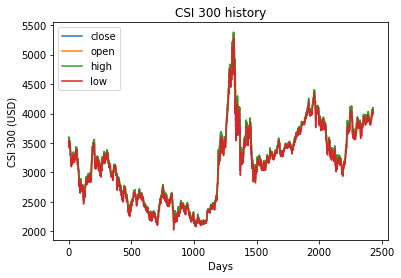

In [11]:
### EDA
plt.figure()
plt.plot(df_feature[["close"]])
plt.plot(df_feature[["open"]])
plt.plot(df_feature[["high"]])
plt.plot(df_feature[["low"]])
plt.title('CSI 300 history')
plt.ylabel('CSI 300 (USD)')
plt.xlabel('Days')
plt.legend(['close', 'open','high','low'], loc='upper left')
plt.show()

In [12]:
df_feature

,close,open,high,low,volume,x(t-1),x(t-2),x(t-3),MA5,MA10,MA20,BIAS5,BIAS10,DIFF,BU,BL,KDJ,KDJ(t-1),ROC,TR（14）,MTM6,MTM12,WR%10,WR%5,OSC6,OSC12,RSI6,RSI12,PSY,OBV,return,(x(t)-xo(t))/xo(t),(x(t)-xl(t))/(xh(t)- xl(t)),(MA5(t)-MA5(t-1))/MA5(t-1),(MA20(t)-MA20(t-1))/MA20(t-1),(MA5(t)-MA20(t-1))/MA20(t-1),(x(t)-MA20(t))/MA20(t)
0,3535.2290,3592.4680,3597.7480,3535.2290,6.610108e+09,3575.6840,3575.6800,3558.8570,3529.79,3455.11850,3508.973800,0.1541,2.3186,-0.7398,3708.899235,3326.960919,77.7282,76.9618,-0.7160,66.1354,96.4120,-25.4940,20.7390,37.906844,-0.1607,-1.912190,58.214907,53.424573,66.666667,1.576110e+10,-0.0113,-0.0159,0.0000,0.006258,-0.003031,0.004383,0.007482
1,3564.0380,3545.1860,3577.5260,3497.6610,8.580964e+09,3535.2290,3575.6840,3575.6840,3546.91,3471.86010,3503.734100,0.4829,2.6550,4.4354,3708.705230,3341.118616,81.4247,77.7282,2.4104,68.8372,139.2550,83.8850,11.1824,22.999093,0.2994,-1.908078,63.228944,55.993992,75.000000,1.584691e+10,0.0081,0.0053,0.8311,0.004850,-0.001493,0.010811,0.017211
2,3541.7270,3558.7000,3588.8320,3541.1730,7.847312e+09,3564.0380,3535.2290,3575.6840,3555.11,3495.47850,3499.619500,-0.3764,1.3231,6.6597,3709.891699,3342.244301,80.3912,81.4247,4.4223,67.9544,63.2940,149.9920,18.5835,55.972304,0.5634,-1.574446,56.885306,53.500459,66.666667,1.576844e+10,-0.0063,-0.0048,0.0116,0.002311,-0.001174,0.014663,0.012032
3,3471.4560,3543.1600,3558.5560,3452.7690,8.035004e+09,3541.7270,3564.0380,3535.2290,3537.63,3508.97610,3495.468400,-1.8705,-1.0693,2.7208,3707.066967,3338.194033,64.4253,80.3912,2.2032,67.8967,-29.2810,74.8340,48.8652,87.110547,0.5234,-1.293455,41.245343,46.400698,66.666667,1.568809e+10,-0.0198,-0.0202,0.1766,-0.004917,-0.001186,0.010861,-0.006870
4,3480.1300,3456.9080,3482.0830,3426.6980,6.079025e+09,3471.4560,3541.7270,3564.0380,3518.52,3513.10740,3490.613050,-1.0910,-0.9387,0.2957,3700.756318,3335.489374,53.3627,64.4253,5.2816,65.1044,-78.7270,174.5870,62.8701,68.762350,0.2812,-0.742377,43.544489,47.341688,66.666667,1.574888e+10,0.0025,0.0067,0.9647,-0.005402,-0.001389,0.006595,-0.003003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2426,3990.8671,3988.6574,4000.5556,3976.3559,9.493889e+09,3992.9581,3967.0962,4017.2527,3999.06,3991.66975,3931.248280,-0.2050,-0.0201,29.5162,4050.547309,3789.291191,59.0441,65.4477,2.4495,36.8824,-50.9325,95.4203,42.1334,67.250737,2.1166,1.426661,56.018210,58.590802,50.000000,4.177024e+10,-0.0005,0.0006,0.5996,-0.002092,0.001468,0.018743,0.015165
2427,4025.9879,3993.6686,4025.9879,3993.5413,1.088606e+10,3990.8671,3992.9581,3967.0962,3998.83,4005.16612,3939.432530,0.6791,0.5199,31.3967,4061.172471,3787.752475,60.6246,59.0441,3.2203,37.6992,-6.7947,125.6036,29.0058,24.967494,1.9755,1.571487,66.959028,63.912328,50.000000,4.187910e+10,0.0088,0.0081,1.0000,-0.000058,0.002082,0.017191,0.021972
2428,4022.0278,4029.2454,4066.7964,4019.7223,1.509264e+10,4025.9879,3990.8671,3992.9581,3999.79,4010.54679,3949.100390,0.5560,0.2863,32.1963,4070.493169,3788.618685,59.2181,60.6246,3.0563,39.1533,-5.1217,119.2786,39.6995,43.409408,1.8273,1.688829,64.778650,62.917741,50.000000,4.172817e+10,-0.0010,-0.0018,0.0490,0.000239,0.002454,0.015321,0.018467
2429,4081.6334,4015.5195,4083.6901,4001.4951,1.559715e+10,4022.0278,4025.9879,3990.8671,4022.69,4019.95549,3961.379115,1.4652,1.5343,37.2108,4087.226847,3789.703361,72.2409,59.2181,4.8987,43.6764,64.3807,190.6092,1.7136,1.713563,1.8678,1.855955,77.822341,70.464660,50.000000,4.188414e+10,0.0148,0.0165,0.9750,0.005727,0.003109,0.018635,0.030357


In [14]:
def get_profit_class(data):
    '''
    classify the price movement direction
    '''
    data_diff = data.diff(-next_n)
    data_diff[data_diff > 0] = 0 # price goes down
    data_diff[data_diff < 0] = 1 # price goes up
    return data_diff

next_n = 1

place_data = get_profit_class(df_feature)
df_feature['signal'] = place_data['close']
df_feature['signal']= df_feature['signal'].shift(next_n).fillna(method='ffill').shift(-next_n).to_frame().fillna(method='ffill')
df_feature

,close,open,high,low,volume,x(t-1),x(t-2),x(t-3),MA5,MA10,MA20,BIAS5,BIAS10,DIFF,BU,BL,KDJ,KDJ(t-1),ROC,TR（14）,MTM6,MTM12,WR%10,WR%5,OSC6,OSC12,RSI6,RSI12,PSY,OBV,return,(x(t)-xo(t))/xo(t),(x(t)-xl(t))/(xh(t)- xl(t)),(MA5(t)-MA5(t-1))/MA5(t-1),(MA20(t)-MA20(t-1))/MA20(t-1),(MA5(t)-MA20(t-1))/MA20(t-1),(x(t)-MA20(t))/MA20(t),signal
0,3535.2290,3592.4680,3597.7480,3535.2290,6.610108e+09,3575.6840,3575.6800,3558.8570,3529.79,3455.11850,3508.973800,0.1541,2.3186,-0.7398,3708.899235,3326.960919,77.7282,76.9618,-0.7160,66.1354,96.4120,-25.4940,20.7390,37.906844,-0.1607,-1.912190,58.214907,53.424573,66.666667,1.576110e+10,-0.0113,-0.0159,0.0000,0.006258,-0.003031,0.004383,0.007482,1.0
1,3564.0380,3545.1860,3577.5260,3497.6610,8.580964e+09,3535.2290,3575.6840,3575.6840,3546.91,3471.86010,3503.734100,0.4829,2.6550,4.4354,3708.705230,3341.118616,81.4247,77.7282,2.4104,68.8372,139.2550,83.8850,11.1824,22.999093,0.2994,-1.908078,63.228944,55.993992,75.000000,1.584691e+10,0.0081,0.0053,0.8311,0.004850,-0.001493,0.010811,0.017211,0.0
2,3541.7270,3558.7000,3588.8320,3541.1730,7.847312e+09,3564.0380,3535.2290,3575.6840,3555.11,3495.47850,3499.619500,-0.3764,1.3231,6.6597,3709.891699,3342.244301,80.3912,81.4247,4.4223,67.9544,63.2940,149.9920,18.5835,55.972304,0.5634,-1.574446,56.885306,53.500459,66.666667,1.576844e+10,-0.0063,-0.0048,0.0116,0.002311,-0.001174,0.014663,0.012032,0.0
3,3471.4560,3543.1600,3558.5560,3452.7690,8.035004e+09,3541.7270,3564.0380,3535.2290,3537.63,3508.97610,3495.468400,-1.8705,-1.0693,2.7208,3707.066967,3338.194033,64.4253,80.3912,2.2032,67.8967,-29.2810,74.8340,48.8652,87.110547,0.5234,-1.293455,41.245343,46.400698,66.666667,1.568809e+10,-0.0198,-0.0202,0.1766,-0.004917,-0.001186,0.010861,-0.006870,1.0
4,3480.1300,3456.9080,3482.0830,3426.6980,6.079025e+09,3471.4560,3541.7270,3564.0380,3518.52,3513.10740,3490.613050,-1.0910,-0.9387,0.2957,3700.756318,3335.489374,53.3627,64.4253,5.2816,65.1044,-78.7270,174.5870,62.8701,68.762350,0.2812,-0.742377,43.544489,47.341688,66.666667,1.574888e+10,0.0025,0.0067,0.9647,-0.005402,-0.001389,0.006595,-0.003003,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2426,3990.8671,3988.6574,4000.5556,3976.3559,9.493889e+09,3992.9581,3967.0962,4017.2527,3999.06,3991.66975,3931.248280,-0.2050,-0.0201,29.5162,4050.547309,3789.291191,59.0441,65.4477,2.4495,36.8824,-50.9325,95.4203,42.1334,67.250737,2.1166,1.426661,56.018210,58.590802,50.000000,4.177024e+10,-0.0005,0.0006,0.5996,-0.002092,0.001468,0.018743,0.015165,1.0
2427,4025.9879,3993.6686,4025.9879,3993.5413,1.088606e+10,3990.8671,3992.9581,3967.0962,3998.83,4005.16612,3939.432530,0.6791,0.5199,31.3967,4061.172471,3787.752475,60.6246,59.0441,3.2203,37.6992,-6.7947,125.6036,29.0058,24.967494,1.9755,1.571487,66.959028,63.912328,50.000000,4.187910e+10,0.0088,0.0081,1.0000,-0.000058,0.002082,0.017191,0.021972,0.0
2428,4022.0278,4029.2454,4066.7964,4019.7223,1.509264e+10,4025.9879,3990.8671,3992.9581,3999.79,4010.54679,3949.100390,0.5560,0.2863,32.1963,4070.493169,3788.618685,59.2181,60.6246,3.0563,39.1533,-5.1217,119.2786,39.6995,43.409408,1.8273,1.688829,64.778650,62.917741,50.000000,4.172817e+10,-0.0010,-0.0018,0.0490,0.000239,0.002454,0.015321,0.018467,1.0
2429,4081.6334,4015.5195,4083.6901,4001.4951,1.559715e+10,4022.0278,4025.9879,3990.8671,4022.69,4019.95549,3961.379115,1.4652,1.5343,37.2108,4087.226847,3789.703361,72.2409,59.2181,4.8987,43.6764,64.3807,190.6092,1.7136,1.713563,1.8678,1.855955,77.822341,70.464660,50.000000,4.188414e+10,0.0148,0.0165,0.9750,0.005727,0.003109,0.018635,0.030357,1.0


In [15]:
data_train = df_feature.iloc[:1944, :]
data_test = df_feature.iloc[1944:, :]
print(data_train.shape, data_test.shape)

(1944, 38) (487, 38)


In [16]:
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(data_train)

# apply transformation to training data
train = scaler.transform(data_train)

# apply same transformation to test data
test = scaler.transform(data_test)

In [17]:
test

array([[0.61235582, 0.59562923, 0.60368137, ..., 0.54891658, 0.56488343,
        1.        ],
       [0.61969983, 0.60964672, 0.61970873, ..., 0.55550612, 0.57778003,
        1.        ],
       [0.62503211, 0.6165144 , 0.61896913, ..., 0.57493449, 0.58514809,
        1.        ],
       ...,
       [0.59234427, 0.59079131, 0.59724825, ..., 0.58984483, 0.57470076,
        1.        ],
       [0.61059023, 0.58663144, 0.60242777, ..., 0.6006854 , 0.60504066,
        1.        ],
       [0.6151662 , 0.60549203, 0.60685938, ..., 0.60747688, 0.60651851,
        1.        ]])

In [18]:
# y train/test: numeric labels, for regression 
y_train = np.array(df_feature.iloc[:1944, 0])
y_test = np.array(df_feature.iloc[1944:, 0])
print(y_train.shape, y_test.shape)

(1944,) (487,)


In [19]:
past_steps = 15
next_steps = 1

In [20]:
X_train = train[:,:-1]
X_test = test[:,:-1]
y_train = train[:,-1]
y_test = test[:,-1]

In [21]:
X_train = np.array([X_train[i : i + past_steps, :] for i in range(0, X_train.shape[0] - (next_steps+ past_steps),1)])
X_test = np.array([X_test[i : i + past_steps, :] for i in range(0, X_test.shape[0] - (next_steps+ past_steps),1)])

In [22]:
X_train.shape

(1928, 15, 37)

In [23]:
y_train_regression = np.array([y_train[i + past_steps + next_steps] for i in range(0,train.shape[0] - (next_steps+ past_steps),1)])
y_test_regression = np.array([y_test[i + past_steps + next_steps] for i in range(0,test.shape[0] - (next_steps+ past_steps),1)])

In [24]:
y_train_regression.shape

(1928,)

In [25]:
ret = df.iloc[1961:, :]
ret = ret['return']
ret

1961   -0.0057
1962    0.0037
1963   -0.0181
1964   -0.0107
1965    0.0047
         ...  
2426   -0.0005
2427    0.0088
2428   -0.0010
2429    0.0148
2430    0.0037
Name: return, Length: 470, dtype: float64

In [40]:
    # create_single_layer_small_rnn_model
    '''
    create single layer rnn model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    model = Sequential()
    model.add(SimpleRNN(6))
    model.add(Dense(1))

    model.compile(optimizer='rmsprop', loss='mean_squared_error')

    # fit the RNN model
    model.fit(X_train, y_train_regression, epochs=100, batch_size=150)

    # Finalizing predictions
    single_layer_small_rnn_preds = model.predict(X_test)
    table_1=pd.DataFrame(columns=['reg_pred', 'class_pred','y_test'],index=ret.index)
    table_1['reg_pred'] = single_layer_small_rnn_preds[:-1]

    # print(model)
    single_layer_small_rnn_preds[single_layer_small_rnn_preds >= 0.5] = 1
    single_layer_small_rnn_preds[single_layer_small_rnn_preds < 0.5] = 0

Train on 1928 samples
Epoch 1/100
1928/1928 [==============================] - 0s 23us/sample - loss: 0.2805
Epoch 2/100
1928/1928 [==============================] - 0s 20us/sample - loss: 0.2589
Epoch 3/100
1928/1928 [==============================] - 0s 23us/sample - loss: 0.2556
Epoch 4/100
1928/1928 [==============================] - 0s 21us/sample - loss: 0.2538
Epoch 5/100
1928/1928 [==============================] - 0s 19us/sample - loss: 0.2529
Epoch 6/100
1928/1928 [==============================] - 0s 20us/sample - loss: 0.2525
Epoch 7/100
1928/1928 [==============================] - 0s 20us/sample - loss: 0.2527
Epoch 8/100
1928/1928 [==============================] - 0s 23us/sample - loss: 0.2515
Epoch 9/100
1928/1928 [==============================] - 0s 20us/sample - loss: 0.2516
Epoch 10/100
1928/1928 [==============================] - 0s 21us/sample - loss: 0.2509
Epoch 11/100
1928/1928 [==============================] - 0s 20us/sample - loss: 0.2515
Epoch 12/100
1928/1

In [42]:
single_layer_small_rnn_preds.shape

(471, 1)

In [43]:
table_1['y_test'] = y_test_regression[:-1]
table_1['class_pred'] = single_layer_small_rnn_preds[:-1]
table_1.to_csv('single-layer-small.csv')

In [41]:

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score

print('accuracy of single layer small rnn:', accuracy_score(y_test_regression, single_layer_small_rnn_preds))
print('recall score of single layer small rnn:', recall_score(y_test_regression, single_layer_small_rnn_preds))

accuracy of single layer small rnn: 0.5435244161358811
recall score of single layer small rnn: 0.6167400881057269


In [44]:
    # create_single_layer_rnn_model
    '''
    create single layer rnn model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    model = Sequential()
    model.add(SimpleRNN(32))
    model.add(Dense(1))

    model.compile(optimizer='rmsprop', loss='mean_squared_error')

    # fit the RNN model
    model.fit(X_train, y_train_regression, epochs=100, batch_size=150)

    # Finalizing predictions
    single_layer_rnn_preds = model.predict(X_test)
    print(model)
    table_2=pd.DataFrame(columns=['reg_pred', 'class_pred','y_test'],index=ret.index)
    table_2['reg_pred'] = single_layer_rnn_preds[:-1]

    single_layer_rnn_preds[single_layer_rnn_preds >= 0.5] = 1
    single_layer_rnn_preds[single_layer_rnn_preds < 0.5] = 0
print('accuracy of single layer rnn:', accuracy_score(y_test_regression, single_layer_rnn_preds))
print('recall score of single layer rnn:', recall_score(y_test_regression, single_layer_rnn_preds))

Train on 1928 samples
Epoch 1/100
1928/1928 [==============================] - 0s 31us/sample - loss: 0.3729
Epoch 2/100
1928/1928 [==============================] - 0s 25us/sample - loss: 0.2651
Epoch 3/100
1928/1928 [==============================] - 0s 27us/sample - loss: 0.2619
Epoch 4/100
1928/1928 [==============================] - 0s 28us/sample - loss: 0.2570
Epoch 5/100
1928/1928 [==============================] - 0s 27us/sample - loss: 0.2550
Epoch 6/100
1928/1928 [==============================] - 0s 27us/sample - loss: 0.2619
Epoch 7/100
1928/1928 [==============================] - 0s 31us/sample - loss: 0.2554
Epoch 8/100
1928/1928 [==============================] - 0s 34us/sample - loss: 0.2520
Epoch 9/100
1928/1928 [==============================] - 0s 27us/sample - loss: 0.2556
Epoch 10/100
1928/1928 [==============================] - 0s 31us/sample - loss: 0.2522
Epoch 11/100
1928/1928 [==============================] - 0s 28us/sample - loss: 0.2507
Epoch 12/100
1928/1

In [45]:
table_2['y_test'] = y_test_regression[:-1]
table_2['class_pred'] = single_layer_rnn_preds[:-1]
table_2.to_csv('single-layer.csv')

In [46]:
    # create_rnn_model
    '''
    create rnn model trained on X_train and y_train
    and make predictions on the X_test data
    '''
    # create a model
    model = Sequential()
    model.add(SimpleRNN(32, return_sequences=True))
    model.add(SimpleRNN(32, return_sequences=True))
    model.add(SimpleRNN(32, return_sequences=True))
    model.add(SimpleRNN(32))
    model.add(Dense(1))

    model.compile(optimizer='rmsprop', loss='mean_squared_error')

    # fit the RNN model
    model.fit(X_train, y_train_regression, epochs=100, batch_size=150)

    # Finalizing predictions
    rnn_preds = model.predict(X_test)
    print(model)
    table_3=pd.DataFrame(columns=['reg_pred', 'class_pred','y_test'],index=ret.index)
    table_3['reg_pred'] = rnn_preds[:-1]
    rnn_preds[rnn_preds >= 0.5] = 1
    rnn_preds[rnn_preds < 0.5] = 0
print('accuracy of multi layer rnn:', accuracy_score(y_test_regression, rnn_preds))
print('recall score of multi layer rnn:', recall_score(y_test_regression, rnn_preds))

Train on 1928 samples
Epoch 1/100
1928/1928 [==============================] - 0s 92us/sample - loss: 0.4396
Epoch 2/100
1928/1928 [==============================] - 0s 95us/sample - loss: 0.2666
Epoch 3/100
1928/1928 [==============================] - 0s 96us/sample - loss: 0.2875
Epoch 4/100
1928/1928 [==============================] - 0s 93us/sample - loss: 0.2598
Epoch 5/100
1928/1928 [==============================] - 0s 93us/sample - loss: 0.2757
Epoch 6/100
1928/1928 [==============================] - 0s 94us/sample - loss: 0.2655
Epoch 7/100
1928/1928 [==============================] - 0s 98us/sample - loss: 0.2687
Epoch 8/100
1928/1928 [==============================] - 0s 95us/sample - loss: 0.2541
Epoch 9/100
1928/1928 [==============================] - 0s 100us/sample - loss: 0.2549
Epoch 10/100
1928/1928 [==============================] - 0s 94us/sample - loss: 0.2644
Epoch 11/100
1928/1928 [==============================] - 0s 90us/sample - loss: 0.2540
Epoch 12/100
1928/

In [47]:
table_3['y_test'] = y_test_regression[:-1]
table_3['class_pred'] = rnn_preds[:-1]
table_3.to_csv('multi-layer-small.csv')

In [53]:
df.iloc[2409:,:]

,date,close,open,high,low,volume,x(t-1),x(t-2),x(t-3),MA5,MA10,MA20,BIAS5,BIAS10,DIFF,BU,BL,KDJ,KDJ(t-1),ROC,TR（14）,MTM6,MTM12,WR%10,WR%5,OSC6,OSC12,RSI6,RSI12,PSY,OBV,return,(x(t)-xo(t))/xo(t),(x(t)-xl(t))/(xh(t)- xl(t)),(MA5(t)-MA5(t-1))/MA5(t-1),(MA20(t)-MA20(t-1))/MA20(t-1),(MA5(t)-MA20(t-1))/MA20(t-1),(x(t)-MA20(t))/MA20(t)
2409,12/2/19,3836.0589,3835.5128,3854.7509,3829.3126,7.741217e+09,3828.6706,3862.3029,3875.6186,3858.86,3876.70065,3905.855520,-0.5909,-1.0484,-16.5550,4002.973090,3817.212110,25.8551,27.5000,-1.7870,39.5765,-13.9359,-69.7981,78.0397,66.875688,-1.2430,-0.792847,33.219539,39.394913,50.000000,4.161671e+10,0.0019,0.0001,0.2652,-0.002180,-0.001815,-0.013826,-0.017870
2410,12/3/19,3851.0873,3829.2120,3851.1205,3811.6281,7.361124e+09,3836.0589,3828.6706,3862.3029,3850.75,3867.10546,3898.269245,0.0088,-0.4142,-17.1787,4002.513797,3811.863888,30.7614,25.8551,-0.6707,40.5411,-27.1188,-26.0019,66.5760,45.673946,-1.2864,-0.774283,41.460238,42.821465,50.000000,4.169032e+10,0.0039,0.0057,0.9992,-0.002102,-0.001942,-0.014108,-0.012103
2411,12/4/19,3849.8190,3841.6627,3852.9922,3831.0747,7.968338e+09,3851.0873,3836.0589,3828.6706,3845.59,3861.30095,3891.516115,0.1100,-0.2974,-17.5728,4002.692842,3807.038150,33.6614,30.7614,-1.4870,40.5492,-41.8343,-58.1101,60.5384,45.704503,-1.4095,-0.840307,40.948505,42.599720,41.666667,4.161063e+10,-0.0003,0.0021,0.8552,-0.001340,-0.001732,-0.013513,-0.010715
2412,12/5/19,3879.3638,3863.6086,3883.4031,3859.8223,8.905119e+09,3849.8190,3851.0873,3836.0589,3849.00,3860.27753,3885.890560,0.7889,0.4944,-15.3244,4002.596781,3806.221773,48.7930,33.6614,-1.7146,40.2327,3.7452,-67.6754,34.6241,5.140759,-1.3812,-0.975585,56.096388,49.274884,50.000000,4.169969e+10,0.0077,0.0041,0.8287,0.000887,-0.001446,-0.010925,-0.001680
2413,12/6/19,3902.3853,3885.0582,3902.3853,3878.7002,7.864889e+09,3879.3638,3849.8190,3851.0873,3863.74,3865.51658,3882.359290,1.0001,0.9538,-11.5517,4002.949335,3807.071788,65.8620,48.7930,-0.1402,38.7254,40.0824,-5.4788,0.0000,0.000000,-1.2212,-1.003062,64.589817,53.838116,58.333333,4.177833e+10,0.0059,0.0045,1.0000,0.003830,-0.000909,-0.005700,0.005158
2414,12/9/19,3895.4468,3909.5297,3911.9682,3885.2507,9.535381e+09,3902.3853,3879.3638,3849.8190,3875.62,3867.24065,3881.982715,0.5116,0.7294,-9.0178,3998.953660,3806.687432,72.1012,65.8620,0.1504,37.4437,66.7762,5.8488,15.4205,16.465401,-0.8734,-0.933693,60.366152,52.291435,58.333333,4.168298e+10,-0.0018,-0.0036,0.3816,0.003074,-0.000097,-0.001736,0.003468
2415,12/10/19,3900.3843,3886.4440,3900.9590,3882.0877,8.626293e+09,3895.4468,3902.3853,3879.3638,3885.48,3868.11375,3881.817490,0.3836,0.8343,-6.5359,3991.123502,3808.537798,77.7968,72.1012,1.3088,35.5736,64.3254,50.3895,10.8120,14.319939,-0.5176,-0.746961,62.462272,53.332213,58.333333,4.176924e+10,0.0013,0.0036,0.9695,0.002544,-0.000043,0.000901,0.004783
2416,12/11/19,3902.7492,3907.1592,3909.3854,3890.3410,9.976548e+09,3900.3843,3895.4468,3902.3853,3896.07,3870.82681,3881.955875,0.1715,0.8247,-4.3282,3977.498062,3814.466038,82.3296,77.7968,0.6328,34.6557,51.6619,24.5431,8.6047,17.679242,-0.1961,-0.594387,63.569661,53.858171,58.333333,4.186901e+10,0.0006,-0.0011,0.6515,0.002725,0.000036,0.003672,0.005356
2417,12/12/19,3891.0242,3908.4537,3908.4537,3886.1188,8.470833e+09,3902.7492,3900.3843,3895.4468,3898.40,3873.69894,3881.214235,-0.1891,0.4473,-3.4846,3965.725065,3819.019235,81.2621,82.3296,-0.0162,30.1556,41.2052,-0.6291,19.5484,62.955393,0.0733,-0.502540,54.078152,50.763774,58.333333,4.178430e+10,-0.0030,-0.0045,0.2196,0.000599,-0.000191,0.004236,0.002528
2418,12/13/19,3968.2211,3928.0044,3969.4568,3925.2757,1.485713e+10,3891.0242,3902.7492,3900.3843,3911.57,3887.65399,3885.770830,1.4484,2.0724,3.3742,3960.304429,3822.620348,87.2471,81.2621,2.3894,32.9843,88.8573,92.6025,0.7829,1.414344,0.4750,-0.279240,78.931561,65.146622,66.666667,4.193287e+10,0.0198,0.0102,0.9720,0.003378,0.001174,0.007821,0.021219


In [54]:
ret = df.iloc[1961:, :]
ret = ret['return']
ret

1961   -0.0057
1962    0.0037
1963   -0.0181
1964   -0.0107
1965    0.0047
         ...  
2426   -0.0005
2427    0.0088
2428   -0.0010
2429    0.0148
2430    0.0037
Name: return, Length: 470, dtype: float64

cumproduct profit of single layer small rnn: 1961    1.005700
1962    1.001979
1963    1.020115
1964    1.009200
1965    1.004456
          ...   
2426    1.283280
2427    1.294573
2428    1.295868
2429    1.315046
2430    1.319912
Name: short, Length: 470, dtype: float64
cumsum profit of single layer small rnn: 1961    0.0057
1962    0.0020
1963    0.0201
1964    0.0094
1965    0.0047
         ...  
2426    0.2903
2427    0.2991
2428    0.3001
2429    0.3149
2430    0.3186
Name: short, Length: 470, dtype: float64


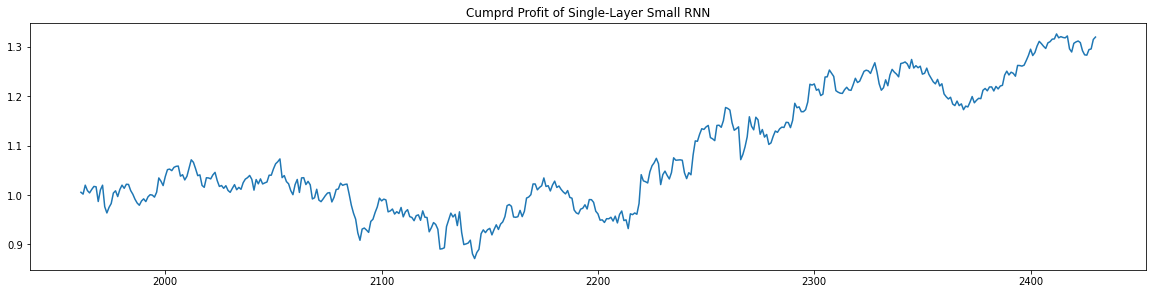

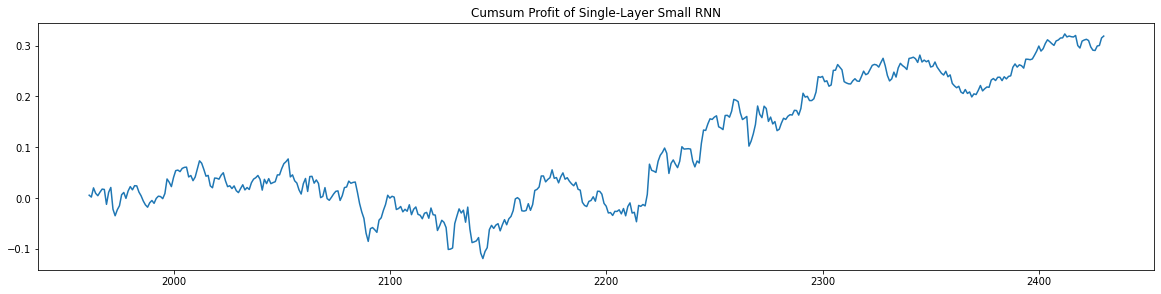

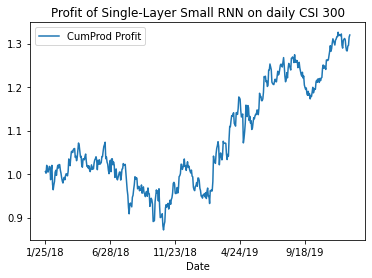

In [65]:
date = df.iloc[1961:, :]['date']
res=pd.DataFrame(columns=['return','signal','multiply','-signal'],index=ret.index)
res['return']=ret
res['signal']=single_layer_small_rnn_preds[:-1]
res['-signal']=1
res['multiply']=res['return']*res['signal']+res['-signal']
res['sum']=res['return']*res['signal']
res['short']=(res['signal']-1/2)*2*res['return']
cumpprofit=res['short']+1
cumpprofit=cumpprofit.cumprod()
print('cumproduct profit of single layer small rnn:', cumpprofit)
cumsprofit=res['short']
cumsprofit=cumsprofit.cumsum()
print('cumsum profit of single layer small rnn:', cumsprofit)
fig = plt.figure(figsize=(20,10))
ax0 = fig.add_subplot(2,1,1)
ax0.plot(cumpprofit)
ax0.set_title('Cumprd Profit of Single-Layer Small RNN')
plt.show()
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2,1,1)
ax1.plot(cumsprofit)
ax1.set_title('Cumsum Profit of Single-Layer Small RNN')
plt.show()
profit_df = pd.DataFrame(columns=['Date', 'profit'])
profit_df['Date'] = date
profit_df['CumProd Profit'] = cumpprofit.values
profit_df.plot(x = 'Date', y = 'CumProd Profit', title = 'Profit of Single-Layer Small RNN on daily CSI 300')
plt.show()

cumproduct profit of single layer rnn: 1961    1.005700
1962    1.009421
1963    0.991151
1964    0.980545
1965    0.975937
          ...   
2426    1.149446
2427    1.159561
2428    1.158402
2429    1.175546
2430    1.179896
Name: short, Length: 470, dtype: float64
cumsum profit of single layer rnn: 1961    0.0057
1962    0.0094
1963   -0.0087
1964   -0.0194
1965   -0.0241
         ...  
2426    0.1803
2427    0.1891
2428    0.1881
2429    0.2029
2430    0.2066
Name: short, Length: 470, dtype: float64


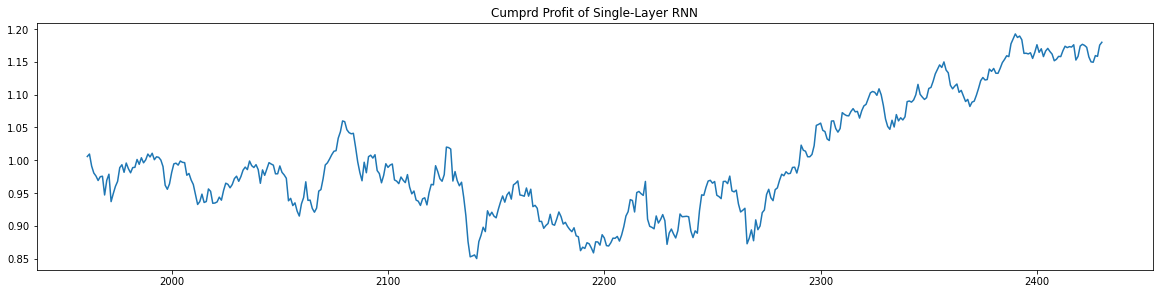

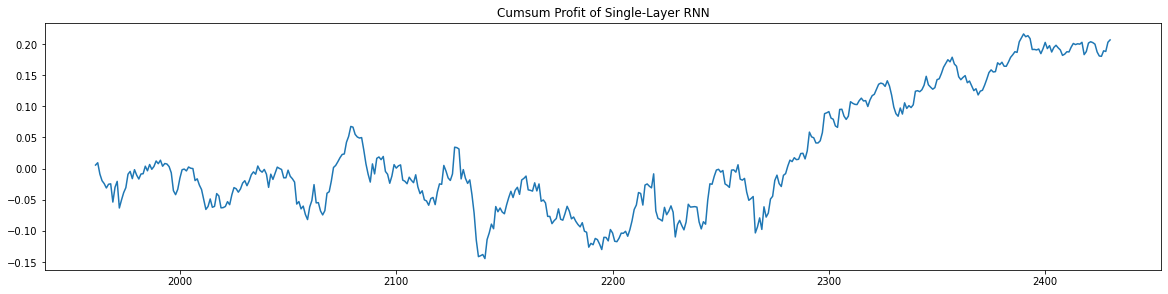

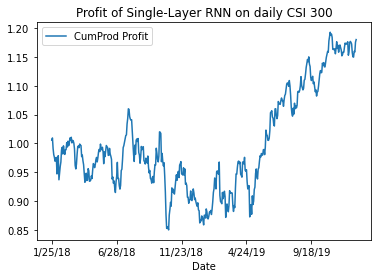

In [66]:
res=pd.DataFrame(columns=['return','signal','multiply','-signal'],index=ret.index)
res['return']=ret
res['signal']=single_layer_rnn_preds[:-1]
res['-signal']=1
res['multiply']=res['return']*res['signal']+res['-signal']
res['sum']=res['return']*res['signal']
res['short']=(res['signal']-1/2)*2*res['return']
cumpprofit=res['short']+1
cumpprofit=cumpprofit.cumprod()
print('cumproduct profit of single layer rnn:', cumpprofit)
cumsprofit=res['short']
cumsprofit=cumsprofit.cumsum()
print('cumsum profit of single layer rnn:', cumsprofit)

fig = plt.figure(figsize=(20,10))
ax0 = fig.add_subplot(2,1,1)
ax0.plot(cumpprofit)
ax0.set_title('Cumprd Profit of Single-Layer RNN')
plt.show()
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2,1,1)
ax1.plot(cumsprofit)
ax1.set_title('Cumsum Profit of Single-Layer RNN')
plt.show()
profit_df = pd.DataFrame(columns=['Date', 'profit'])
profit_df['Date'] = date
profit_df['CumProd Profit'] = cumpprofit.values
profit_df.plot(x = 'Date', y = 'CumProd Profit', title = 'Profit of Single-Layer RNN on daily CSI 300')
plt.show()

cumproduct profit of multi layer rnn: 1961    1.005700
1962    1.009421
1963    1.027692
1964    1.038688
1965    1.033806
          ...   
2426    1.208712
2427    1.198076
2428    1.199274
2429    1.217023
2430    1.221526
Name: short, Length: 470, dtype: float64
cumsum profit of multi layer rnn: 1961    0.0057
1962    0.0094
1963    0.0275
1964    0.0382
1965    0.0335
         ...  
2426    0.2305
2427    0.2217
2428    0.2227
2429    0.2375
2430    0.2412
Name: short, Length: 470, dtype: float64


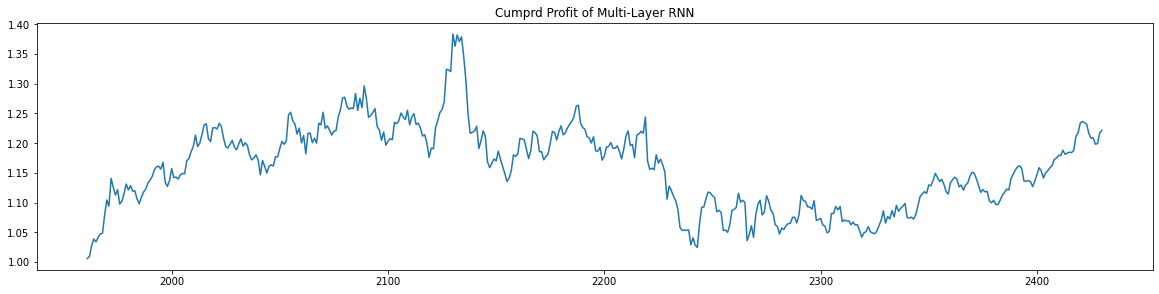

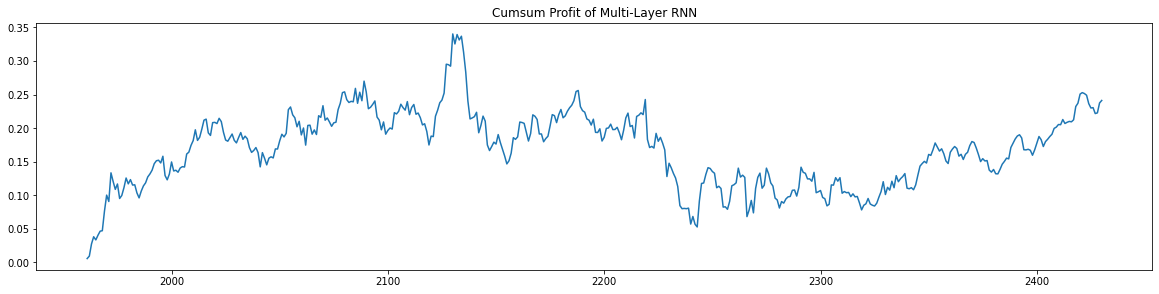

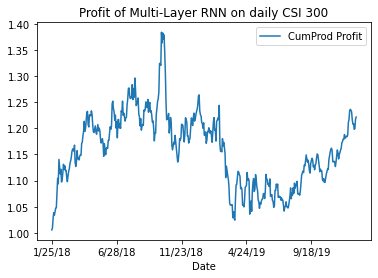

In [67]:
res=pd.DataFrame(columns=['return','signal','multiply','-signal'],index=ret.index)
res['return']=ret
res['signal']=rnn_preds[:-1]
res['-signal']=1
res['multiply']=res['return']*res['signal']+res['-signal']
res['sum']=res['return']*res['signal']
res['short']=(res['signal']-1/2)*2*res['return']
cumpprofit=res['short']+1
cumpprofit=cumpprofit.cumprod()
print('cumproduct profit of multi layer rnn:', cumpprofit)
cumsprofit=res['short']
cumsprofit=cumsprofit.cumsum()
print('cumsum profit of multi layer rnn:', cumsprofit)

fig = plt.figure(figsize=(20,10))
ax0 = fig.add_subplot(2,1,1)
ax0.plot(cumpprofit)
ax0.set_title('Cumprd Profit of Multi-Layer RNN')
plt.show()
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(2,1,1)
ax1.plot(cumsprofit)
ax1.set_title('Cumsum Profit of Multi-Layer RNN')
plt.show()
profit_df = pd.DataFrame(columns=['Date', 'profit'])
profit_df['Date'] = date
profit_df['CumProd Profit'] = cumpprofit.values
profit_df.plot(x = 'Date', y = 'CumProd Profit', title = 'Profit of Multi-Layer RNN on daily CSI 300')
plt.show()

In [58]:
marketcump=(ret+1).cumprod()
marketcump

1961    0.994300
1962    0.997979
1963    0.979915
1964    0.969430
1965    0.973987
          ...   
2426    0.909738
2427    0.917744
2428    0.916826
2429    0.930395
2430    0.933837
Name: return, Length: 470, dtype: float64

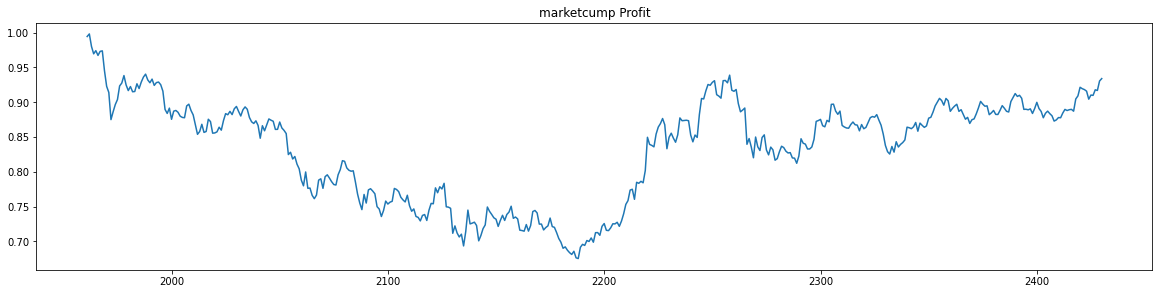

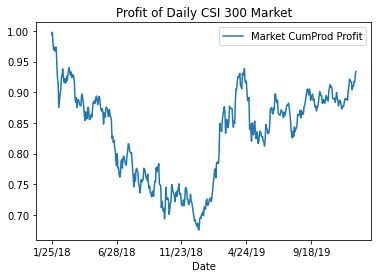

In [68]:
fig = plt.figure(figsize=(20,10))
ax3 = fig.add_subplot(2,1,1)
ax3.plot(marketcump)
ax3.set_title('marketcump Profit')
plt.show()
mkt_df = pd.DataFrame(columns=['Date', 'Market CumProd Profit'])
mkt_df['Date'] = date
profit_df['Market CumProd Profit'] = marketcump.values
profit_df.plot(x = 'Date', y = 'Market CumProd Profit', title = 'Profit of Daily CSI 300 Market')
plt.show()

In [60]:
marketcums=ret.cumsum()
marketcums

1961   -0.0057
1962   -0.0020
1963   -0.0201
1964   -0.0308
1965   -0.0261
         ...  
2426   -0.0537
2427   -0.0449
2428   -0.0459
2429   -0.0311
2430   -0.0274
Name: return, Length: 470, dtype: float64

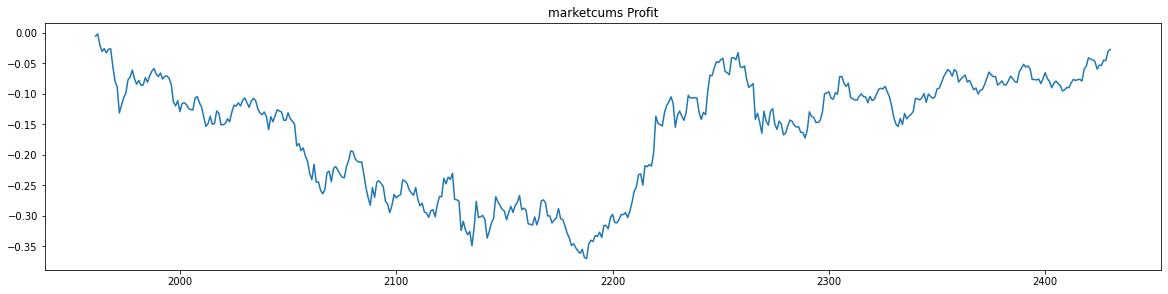

In [61]:
fig = plt.figure(figsize=(20,10))
ax2 = fig.add_subplot(2,1,1)
ax2.plot(marketcums)
ax2.set_title('marketcums Profit')
plt.show()